In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crude-oil-price/crude-oil-price.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.style.use('fivethirtyeight')

In [3]:
class CFG:
    IMDIM1 = 15
    IMDIM2 = 10

In [4]:
plt.rcParams.update({'figure.figsize': (CFG.IMDIM1, CFG.IMDIM2)})

\begin{equation}
X_t = T_t + S_t +C_t + \epsilon_t
\end{equation}
This is called the structural decomposition of a time series function. 
* `T` here is a deterministic component called trend. 
* `S_t` is the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Examples include daily power consumption patterns or annual sales of seasonal goods.
* `C_t` is optional cyclic component which doesn't occur in fixed intervals (usualli makes sense in context of business). 
* `E` is the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations.

In [5]:
df = pd.read_csv('/kaggle/input/crude-oil-price/crude-oil-price.csv')
df.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646396,1.36
2,1983-05-02T00:00:00,30.25,-1.240614,-0.38
3,1983-06-01T00:00:00,31.38,3.735537,1.13
4,1983-07-01T00:00:00,32.00,1.975781,0.62


In [6]:
df.fillna(0, inplace = True)

<AxesSubplot:xlabel='date'>

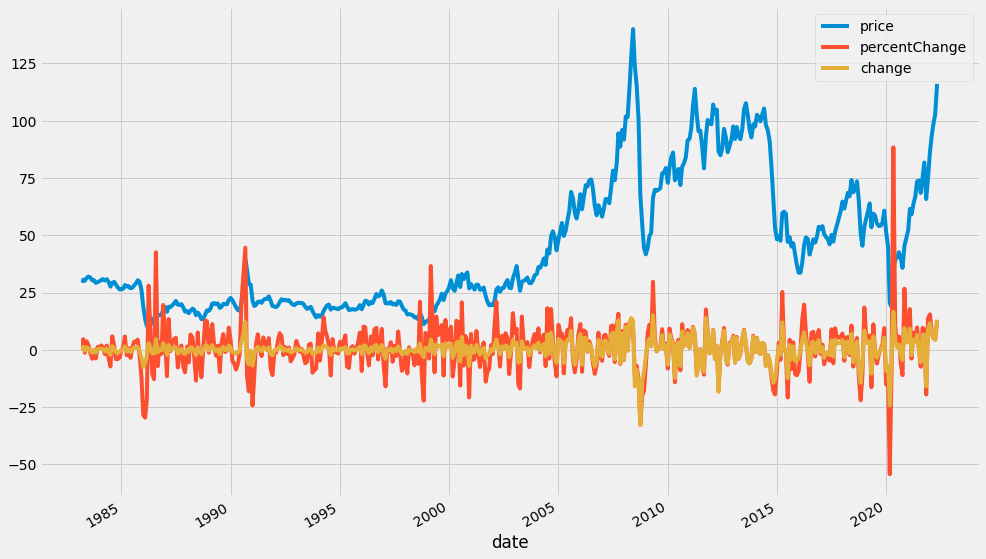

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

## We want to see the trend of oil prices over time. 
We know that oil prices change on a daily basis so our preiod will be 7 and for now we are ignoring the cyclic component to simplify our analysis.

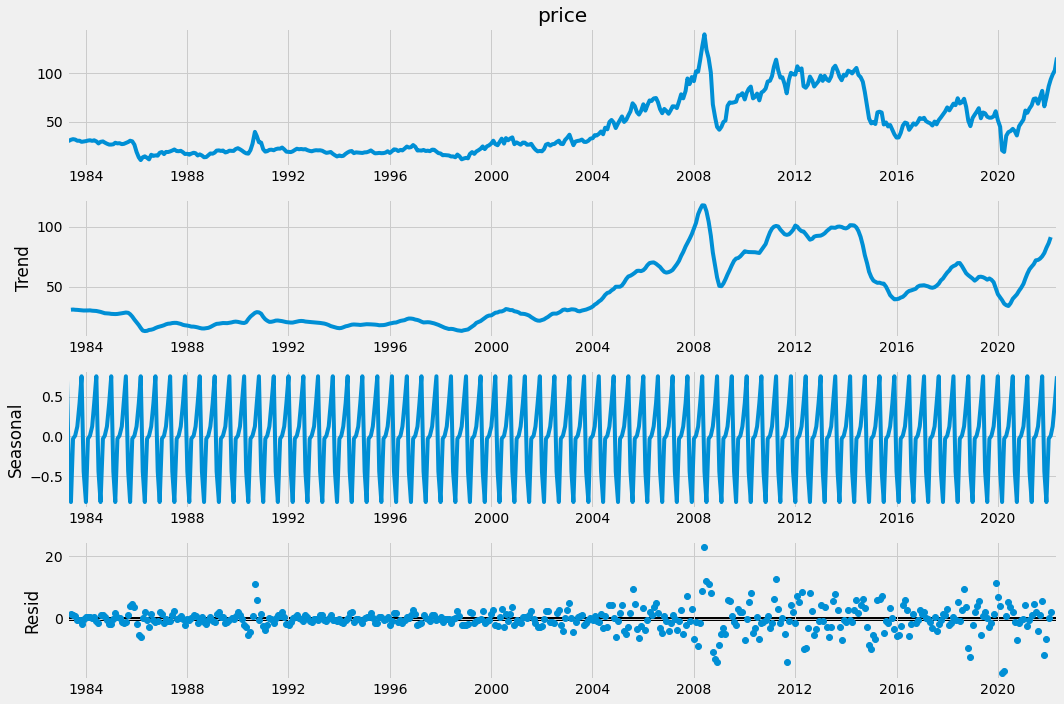

In [8]:
decomposition = seasonal_decompose(df['price'], period = 7)
figure = decomposition.plot()
plt.show()

* The first plot is the original data. 
* The second plot is the trend component which gives us the deterministic component that we can fit to the data.
* The the third plot is the seasonal component. We can verify that there is in fact a seasonal i.e weekly pattern.
* The last plot is the residuals which are data points that the model could not undertand and figure out a trend. So the model plots them as thinking it's white noise. **Note**: *However upon close inspection of the residual component we see that in the far left the residuals are very close to zero and moving rightwards there are big differences between the data points. You can verify this trend from the original graph where we started out with minuscule changes in oil prices as we start off but there are huge peaks as the move onwards from 2004.*

*It can mean that our series is in its multiplicative dynamics or the trend is multiplied by seasonality.* let us check this assumption

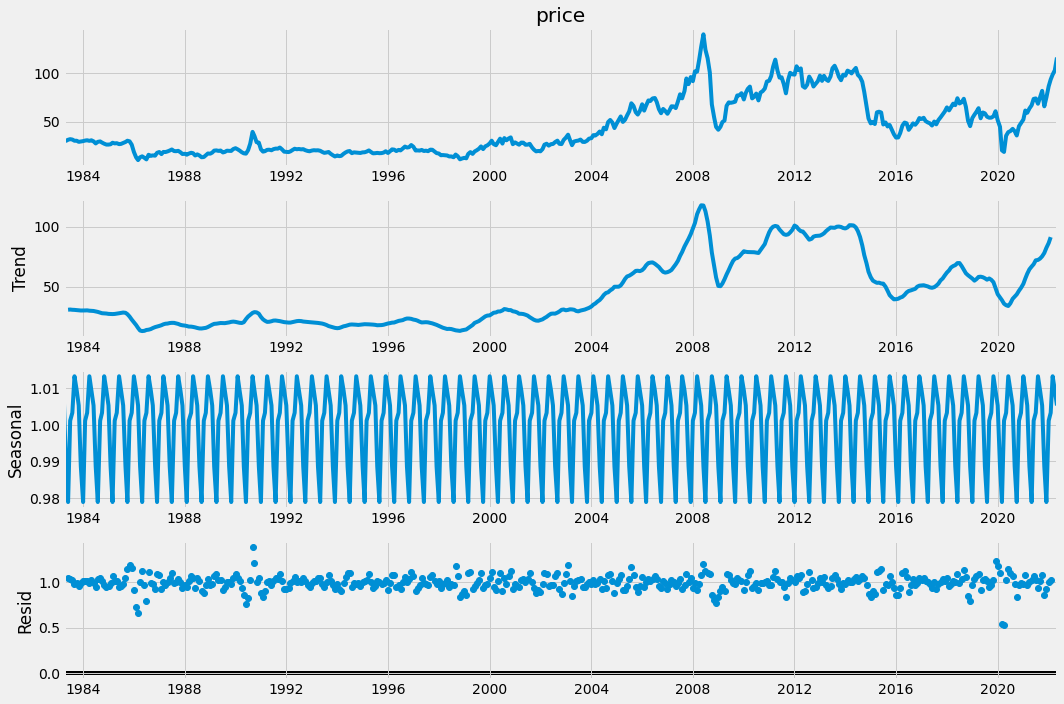

In [9]:
mul_decomposition = seasonal_decompose(df['price'], period = 7, model = 'multiplicative')
figure = mul_decomposition.plot()
plt.show()

We want residuals to be close to white noise

## Finding out if there is dependence
Autocorrelation is correlation with the series itself, every point tells us the average correlation between each observation and it's predecessor

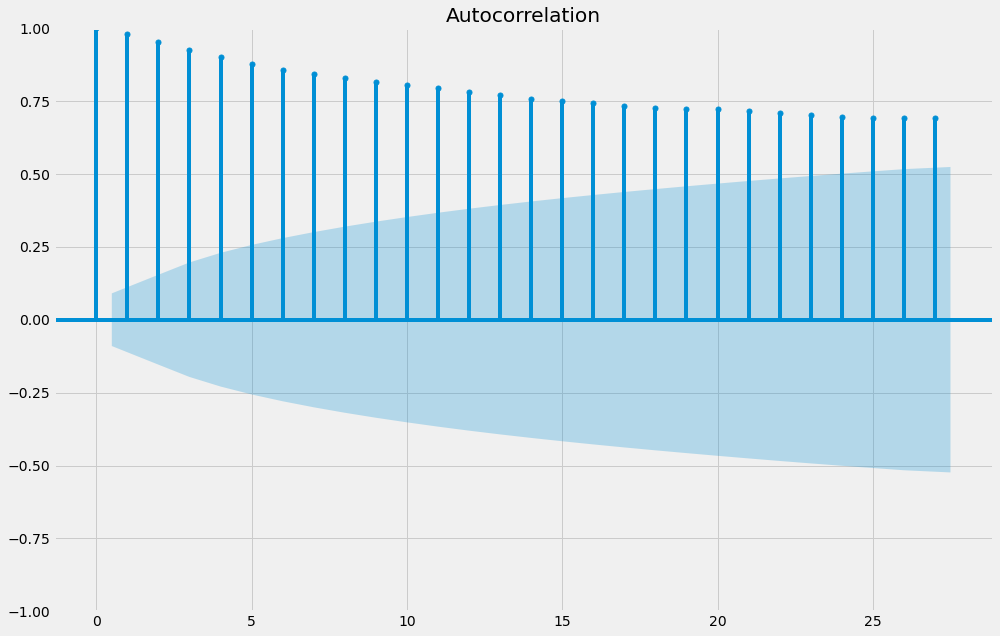

In [10]:
plot_acf(df['price'])
print()


pacf is the same as above but it takes into account observations from in between

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


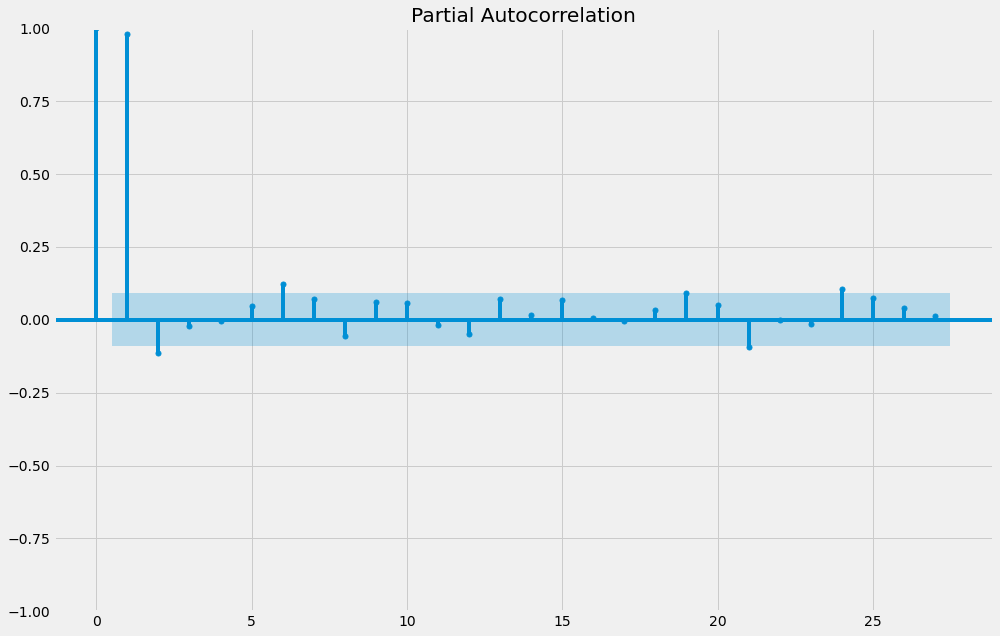

In [11]:
plot_pacf(df['price'])
print()

Rule of thumb: If we expect the trend to increase by a constant amount then additive but if we expect the trend to increase by some multiple then we use multiplicaive assumption

# Exponential smoothing

In [12]:
cutoff_date = '2004-12-31'
xtrain, xvalid = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)


(262, 3) (209, 3)


In [13]:
fit1 = ExponentialSmoothing(df['price'].values, seasonal_periods = 7, trend = 'mul', seasonal = 'mul')

In [14]:
fit1 = fit1.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [15]:
prediction = fit1.forecast(len(xvalid)).copy()
xresiduals = xvalid['price'] - prediction

In [16]:
fit1.params_formatted


,name,param,optimized
smoothing_level,alpha,NaN,True
smoothing_trend,beta,NaN,True
smoothing_seasonal,gamma,NaN,True
initial_level,l.0,NaN,True
initial_trend,b.0,NaN,True
initial_seasons.0,s.0,NaN,True
initial_seasons.1,s.1,NaN,True
initial_seasons.2,s.2,NaN,True
initial_seasons.3,s.3,NaN,True
initial_seasons.4,s.4,NaN,True


/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


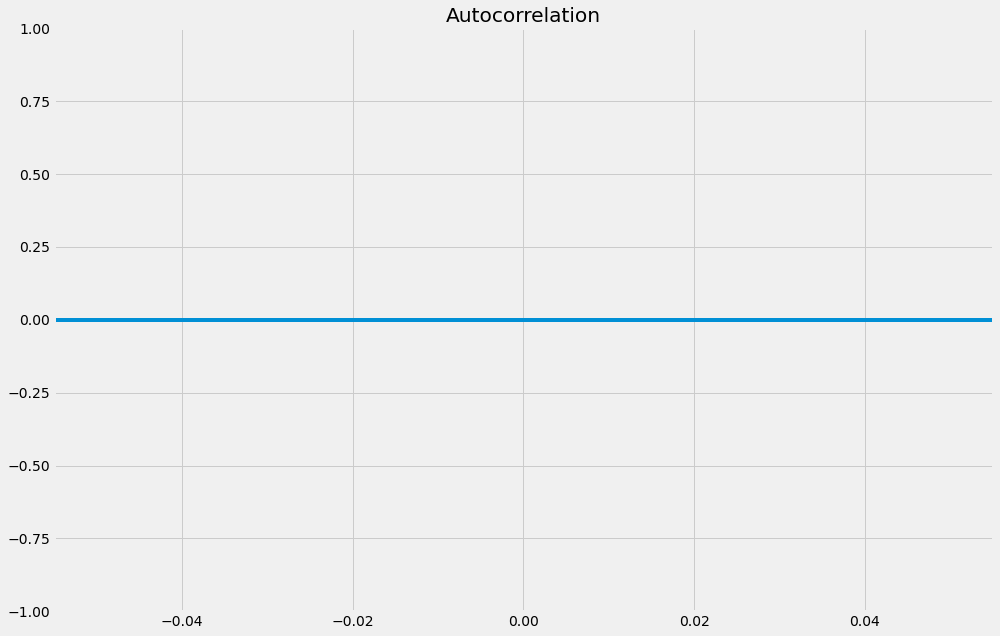

In [17]:
plot_acf(xresiduals, lags = 25)
print()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


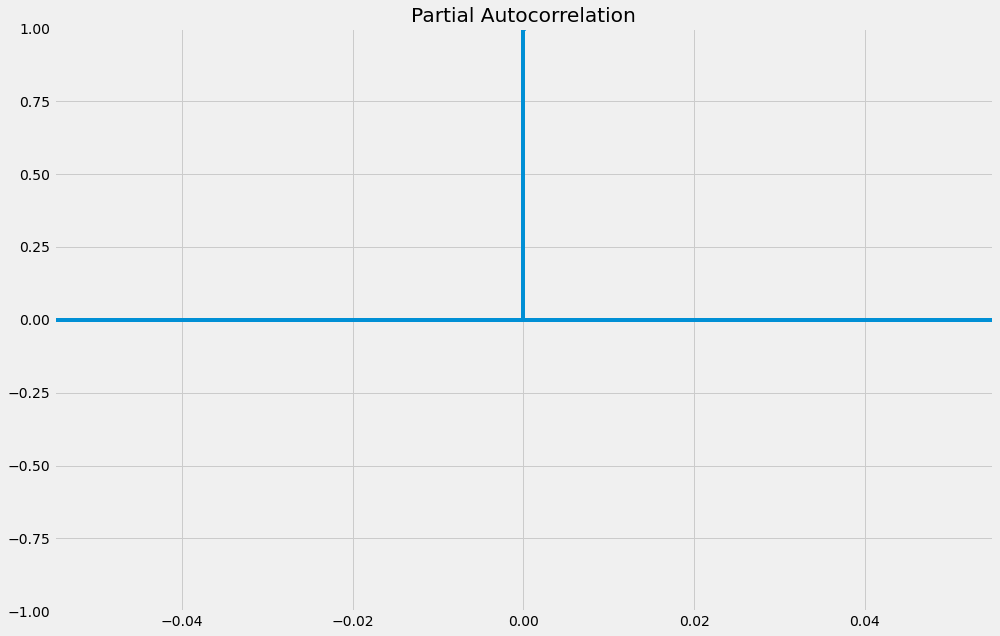

In [18]:
plot_pacf(xresiduals, lags = 25)
print()